<a href="https://colab.research.google.com/github/ksulaiman1/MCS7204-Deep-Learning-Project/blob/main/chest_opacity_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [209]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow.keras import Model,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation,add
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, SeparableConv2D, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras import regularizers
from tensorflow.keras import Model

from sklearn.model_selection import train_test_split


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
%cd drive/MyDrive/deep_learning_project/dataset1/known_images

[Errno 2] No such file or directory: 'drive/MyDrive/deep_learning_project/dataset1/known_images'
/content/drive/MyDrive/deep_learning_project/dataset1/known_images


In [4]:
!ls

normal	Resized_Shapes	sick


In [49]:
# normal = normal_dir.glob("*.png")
# sick = sick_dir.glob("*.png")
train_data = []
for img in glob.glob('normal/*.png'):
  train_data.append((img,0))

for img in glob.glob('sick/*.png'):
  train_data.append((img,1))


In [50]:
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

In [51]:
train_data.head(10)

,image,label
0,normal/normal_663.png,0
1,normal/normal_285.png,0
2,normal/normal_341.png,0
3,normal/normal_210.png,0
4,normal/normal_360.png,0
5,normal/normal_335.png,0
6,normal/normal_89.png,0
7,normal/normal_330.png,0
8,normal/normal_235.png,0
9,normal/normal_118.png,0


In [10]:
train_data.shape

(715, 2)

In [11]:
train_data['label'].value_counts()

0    364
1    351
Name: label, dtype: int64

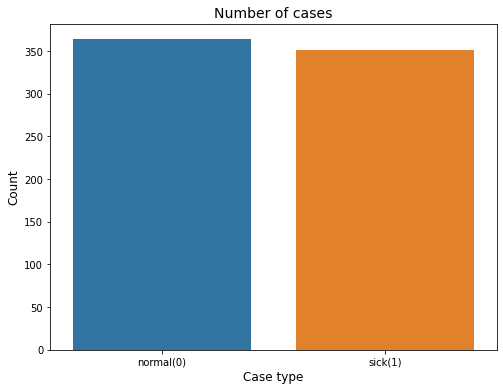

In [52]:
cases_count = train_data['label'].value_counts()
# Plot the results 
plt.figure(figsize=(8,6))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['normal(0)', 'sick(1)'])
plt.show()

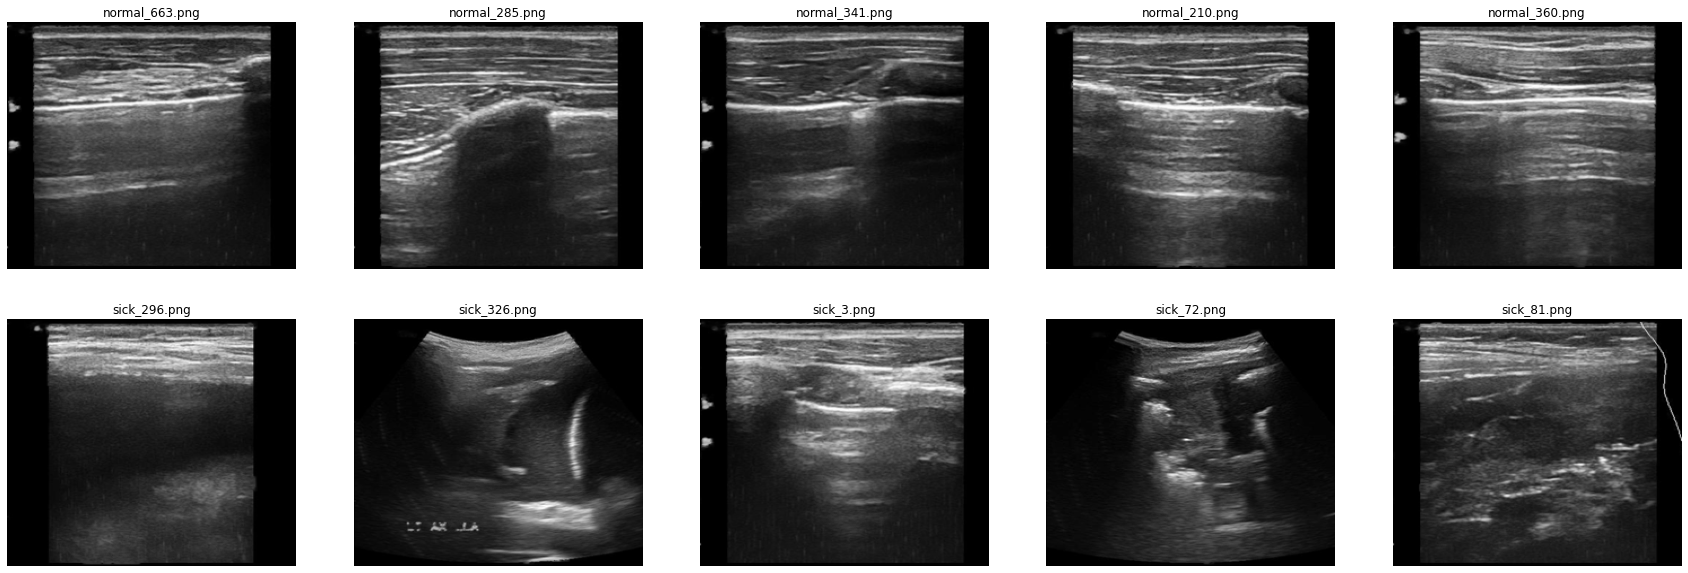

In [53]:
sick_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = normal_samples + sick_samples
del sick_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = Image.open(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title(samples[i].split("/")[1])
    else:
        ax[i//5, i%5].set_title(samples[i].split("/")[1])
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [54]:
BATCH_SIZE = 25
IMAGE_SIZE = 256
EPOCHS = 100
TARGET_CHANNELS = 3

In [55]:
image_dir = "/content/drive/.shortcut-targets-by-id/1IEdSpuN6_4wSIu1hNEtIadLohTemYWRM/deep_learning_project/dataset1/known_images"
train_data['label'] = train_data['label'].astype('str')

In [56]:
train_set, valid_set = train_test_split(train_data, test_size = 0.3, shuffle=True)
val_set, test_set  = train_test_split(valid_set, test_size = 0.1)

In [57]:
train_set.shape, val_set.shape, test_set.shape

((500, 2), (193, 2), (22, 2))

In [58]:
train_set['label'].value_counts()


0    255
1    245
Name: label, dtype: int64

In [59]:
val_set['label'].value_counts()


0    99
1    94
Name: label, dtype: int64

In [60]:
test_set['label'].value_counts()

1    12
0    10
Name: label, dtype: int64

In [61]:
#Training  Augumentation
datagen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.10,
                              height_shift_range=0.10,
                              shear_range=0.1,
                              horizontal_flip=True,
                             fill_mode='nearest',
                             )

In [188]:
#training data generator
train_datagen = datagen.flow_from_dataframe(dataframe= train_set,
                                
                                            directory = image_dir,
                                            x_col = "image",
                                            y_col = "label",
                                            target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size = 1,
                                            class_mode = "binary",
                                            # color_mode='grayscale'
                                            shuffle=True
                                            )

Found 500 validated image filenames belonging to 2 classes.


In [190]:


validation_datagen = ImageDataGenerator()


valid_datagen = validation_datagen.flow_from_dataframe(val_set,
                                            directory = image_dir,
                                            x_col = "image",
                                            y_col = "label",
                                            target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size = 1,
                                            class_mode = "binary",
                                            shuffle=True
                                            
                                            # color_mode='grayscale'
                                            )

Found 193 validated image filenames belonging to 2 classes.


In [191]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
                                dataframe = test_set,
	                              directory = image_dir,
	                              x_col = "image",
                                y_col = "label",
                                target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                batch_size = 1,
                                class_mode = "binary",
                                shuffle=True
                                            
                                # color_mode='grayscale'
                                )

Found 22 validated image filenames belonging to 2 classes.


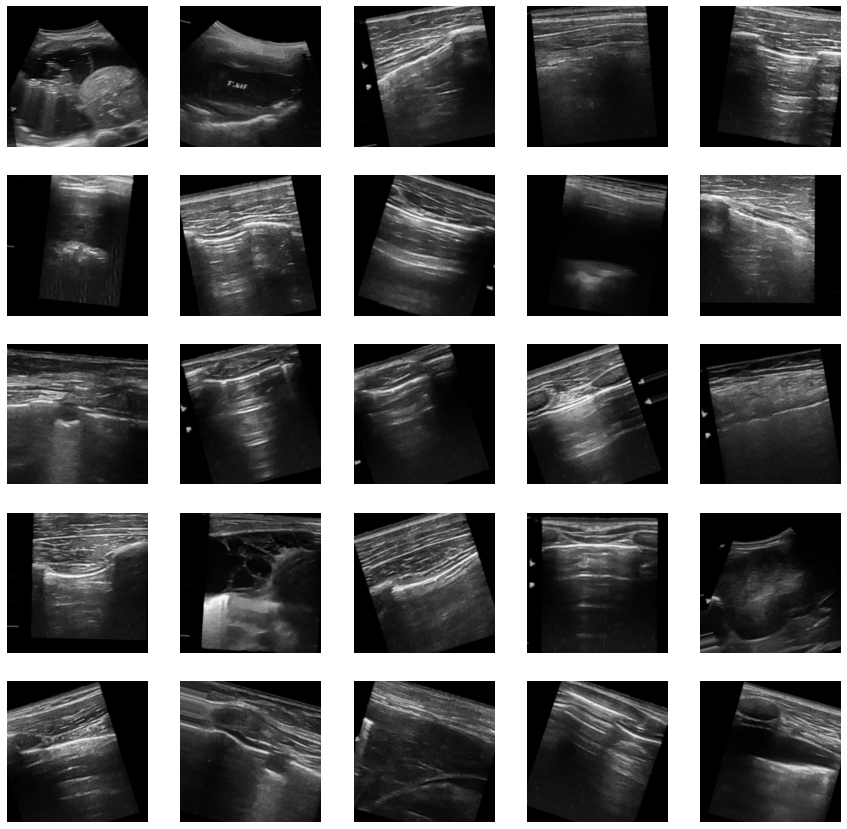

In [24]:
plt.figure(figsize=(15,15))
for i in range(1, 26):
  plt.subplot(5, 5, i)
  # convert to unsigned integers for plotting
  bat = train_datagen.next()
  image = bat[0][0].astype('uint8')

 
  plt.imshow(image)
  # plt.gca().set_title(str(bat[1][i-1].astype('int')))
 
  plt.axis('off')

In [210]:
input = Input(shape =(256,256,3))
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(input)
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x) 
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x) 
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x) 
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# 4th Conv block

x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# 5th Conv block

x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

x = Flatten()(x) 
x = Dense(units = 4096, activation ='relu')(x) 
x = Dense(units = 4096, activation ='relu')(x) 
output = Dense(units = 1, activation ='sigmoid')(x)

model1 = Model (inputs=input, outputs =output)
model1.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_160 (Conv2D)         (None, 256, 256, 64)      1792      
                                                                 
 conv2d_161 (Conv2D)         (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_145 (MaxPooli  (None, 128, 128, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_162 (Conv2D)         (None, 128, 128, 128)     73856     
                                                                 
 conv2d_163 (Conv2D)         (None, 128, 128, 128)     147584    
                                                           

In [192]:
model = Sequential()
model.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l1_l2(1e-4), input_shape = (256, 256, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l1_l2(1e-4), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3),kernel_regularizer=regularizers.l1_l2(1e-4), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(128, (3, 3),kernel_regularizer=regularizers.l1_l2(1e-4), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(256, (3, 3),kernel_regularizer=regularizers.l1_l2(1e-4), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [195]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_142 (Conv2D)         (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_135 (MaxPooli  (None, 127, 127, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_143 (Conv2D)         (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_136 (MaxPooli  (None, 62, 62, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_144 (Conv2D)         (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_137 (MaxPooli  (None, 30, 30, 64)     

In [196]:
model.compile(optimizer = Adam(learning_rate=1e-4), loss = "binary_crossentropy", metrics = ["accuracy"])

In [197]:
# filepath = "chest_opacity.h5"
# initial_learning_rate = 0.0001
# epochs = 150
# decay = initial_learning_rate / epochs
# def lr_time_based_decay(epoch, learning_rate):
#     return learning_rate * 1 / (1 + decay * epoch)

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay)   
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1),
             EarlyStopping(monitor='val_loss', patience=3,),
             ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True),
            # lr_schedule
             ]

In [198]:
history = model.fit(train_datagen, epochs = 200, validation_data = valid_datagen, batch_size=1)


Epoch 1/200
500/500 [==============================] - 108s 21ms/step - loss: 4.9816 - accuracy: 0.7060 - val_loss: 3.9741 - val_accuracy: 0.8705
Epoch 2/200
500/500 [==============================] - 11s 21ms/step - loss: 3.9387 - accuracy: 0.7780 - val_loss: 3.5737 - val_accuracy: 0.8653
Epoch 3/200
500/500 [==============================] - 11s 21ms/step - loss: 3.4325 - accuracy: 0.8200 - val_loss: 3.2574 - val_accuracy: 0.8342
Epoch 4/200
500/500 [==============================] - 12s 24ms/step - loss: 3.1052 - accuracy: 0.8460 - val_loss: 2.8842 - val_accuracy: 0.9016
Epoch 5/200
500/500 [==============================] - 11s 21ms/step - loss: 2.7992 - accuracy: 0.8580 - val_loss: 2.5232 - val_accuracy: 0.9378
Epoch 6/200
500/500 [==============================] - 10s 21ms/step - loss: 2.5458 - accuracy: 0.8520 - val_loss: 2.2385 - val_accuracy: 0.9534
Epoch 7/200
500/500 [==============================] - 11s 21ms/step - loss: 2.2838 - accuracy: 0.8700 - val_loss: 2.0305 - val_a

In [199]:
his = history.history
his.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

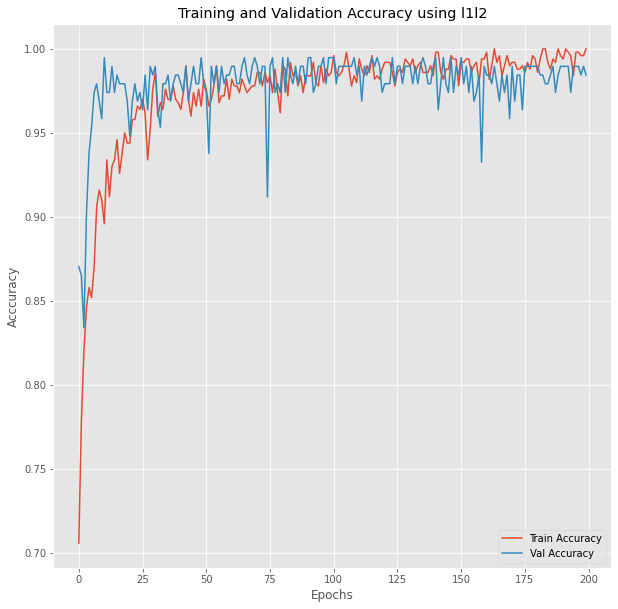

In [204]:
plt.figure(figsize=(10, 10))
plt.plot(his['accuracy'], label='Train Accuracy')
plt.plot(his['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy using l1l2')
plt.xlabel('Epochs')
plt.ylabel('Acccuracy')
plt.legend();

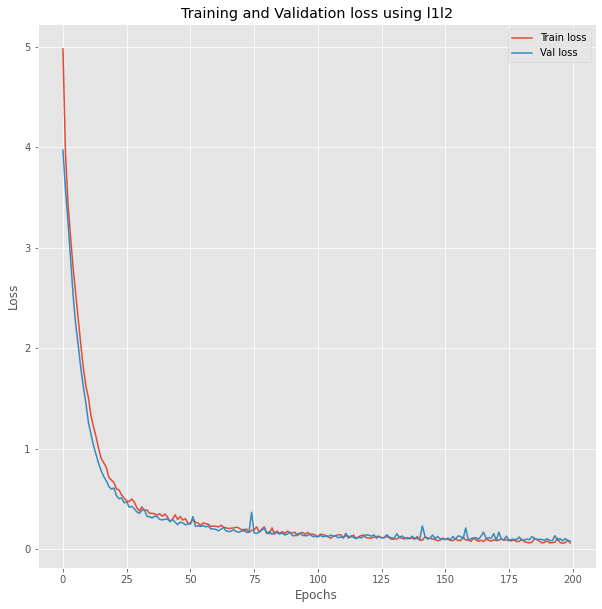

In [205]:
plt.figure(figsize=(10, 10))
plt.plot(his['loss'], label='Train loss')
plt.plot(his['val_loss'], label='Val loss')
plt.title('Training and Validation loss using l1l2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();